In [17]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import skew, kurtosis
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from scipy.special import boxcox1p

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV

In [18]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test= pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
description= open('../input/house-prices-advanced-regression-techniques/data_description.txt').read()

In [19]:
test_id = df_test["Id"]

In [20]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# EDA

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [22]:
df_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [23]:
desc_dict ={}
for radek in description.splitlines():
  if radek.split(':')[0] in df_train.columns:
    desc_dict[radek.split(':')[0]] = radek.split(':')[1]    

def des_object(df, varname):
    table = vcounts = df[varname].value_counts()
    vcounts_len = len(vcounts)
    std = round(float(df[[varname,'SalePrice']].groupby(varname).agg(['mean']).std()),0)
    description = desc_dict[str(varname)] if varname in desc_dict.keys() else ''
    print("")
    print("*********************************")

    plt.figure(figsize=(16,5))
    sns.set_style("whitegrid")
    plt.subplot(121)
    plt.axis([0, 10, 0, 10])
    i = 7.5
    plt.text(0, 8.5, f"there is: {vcounts_len} different values", horizontalalignment='left', fontsize=12 )
    for row in range(np.min([len(table),10])):
      text = table.index[row] + ": " + str(table.iloc[row])      
      plt.text(0, i, text, horizontalalignment='left', fontsize=12 )
      i-=0.5
    plt.text(0, i-0.5, f"std: {std}", horizontalalignment='left', fontsize=12 )
    plt.text(0, 9.5, description, horizontalalignment='left', fontsize=12 )
    plt.text(0, 9, '-------------------------------------------------------', horizontalalignment='left', fontsize=12 )
    plt.title(varname + "| type:" + str(df[varname].dtype),loc='left', weight = 'bold')
    plt.axis('off')  
    plt.subplot(122)    
    g = sns.boxenplot(x = varname, y='SalePrice', data = df,showfliers = False)
    sns.pointplot(x = varname, y='SalePrice', data = df,linestyles='--', scale=0.4, 
              color='k', capsize=0)
    g.set_title(varname)
    plt.xlabel('')
    plt.xticks(rotation=90)      
    plt.tight_layout()
    plt.show()
    print("*********************************")
    print("")
    
def des_numeric(df, varname):
    print("*********************************")    
    table = pd.DataFrame(df[varname].describe().round(2))
    skw = skew(df[varname], axis=0, bias=True)
    kts = kurtosis(df[varname], axis=0, bias=True)    
    description = desc_dict[str(varname)] if varname in desc_dict.keys() else ''
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.axis([0, 10, 0, 10])
    i = 8.5
    for row in range(len(table)):
      text = table.index[row] + ": " + str(table.iloc[row,0])      
      plt.text(0, i, text, horizontalalignment='left', fontsize=12 )
      i-=0.5
    
    plt.text(0, 9.5, description, horizontalalignment='left', fontsize=12 )
    plt.text(0, 9, '-------------------------------------------------------', horizontalalignment='left', fontsize=12 )
    plt.text(0, i, f"NA values: {df[varname].isna().sum()}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-0.5, f"unique values: {df[varname].nunique()}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-1.5, f"skew: {round(skw,2)}", horizontalalignment='left', fontsize=12 )
    plt.text(0, i-2, f"kurtosis: {round(kts,2)}", horizontalalignment='left', fontsize=12 )

    plt.title(varname + "| type:" + str(df[varname].dtype),loc='left', weight = 'bold')
    plt.axis('off')

    plt.subplot(132)
    g= sns.histplot(data=df[varname],alpha=1, kde = True)
    g.set_title('Histogram')
    plt.subplot(133)
    g1 = sns.boxplot(data=df[varname], palette=['#7FFF00'])
    g1.set_title('Boxplot')
    plt.xticks([])
    plt.tight_layout()
    plt.show()
    
def des_df(df):
    for c in df.columns:
        if df[c].dtype == object:
            des_object(df,c)
        else:
            des_numeric(df,c)

**Detailed look to all features, description included**

*********************************


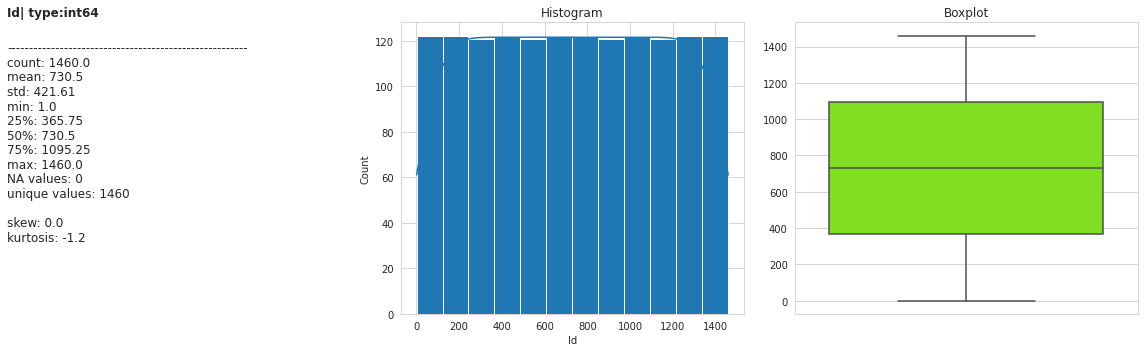

*********************************


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Glyph 9 (	) missing from current font.
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


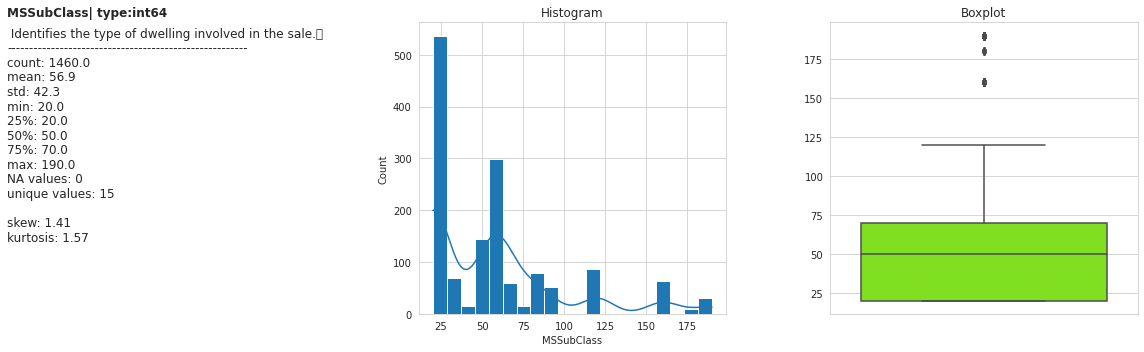

*********************************


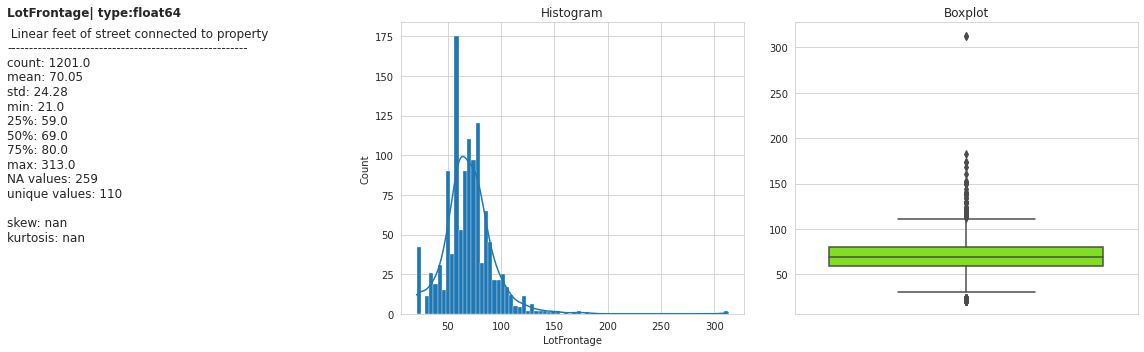

*********************************


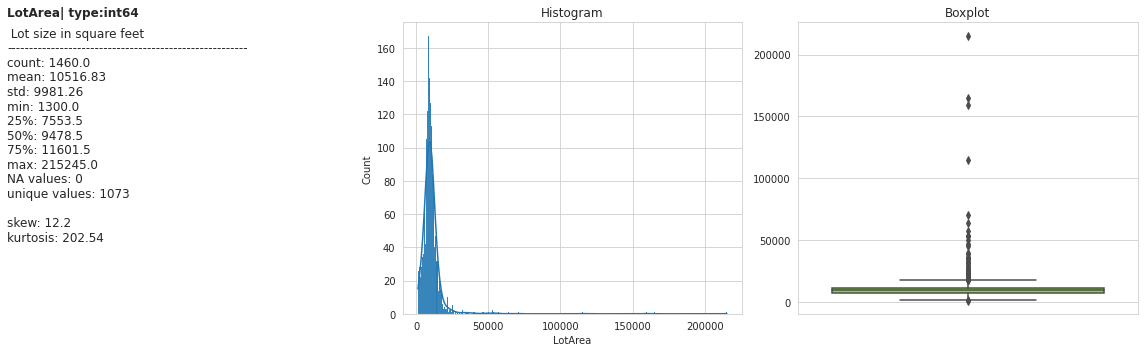

*********************************


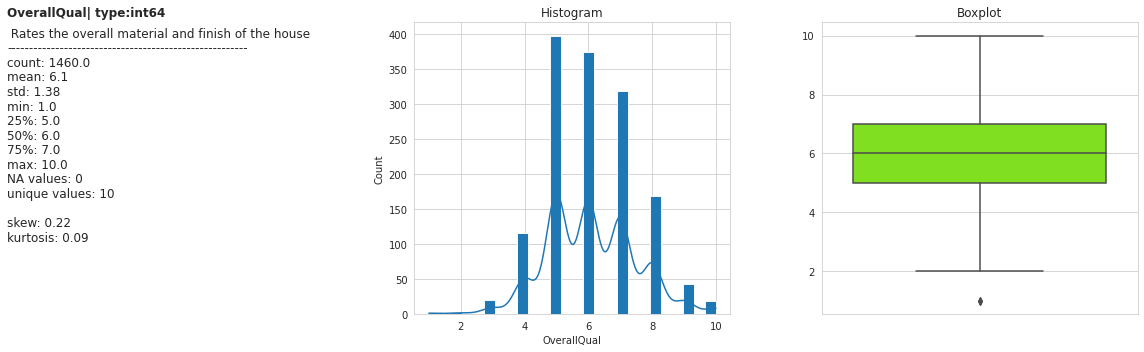

*********************************


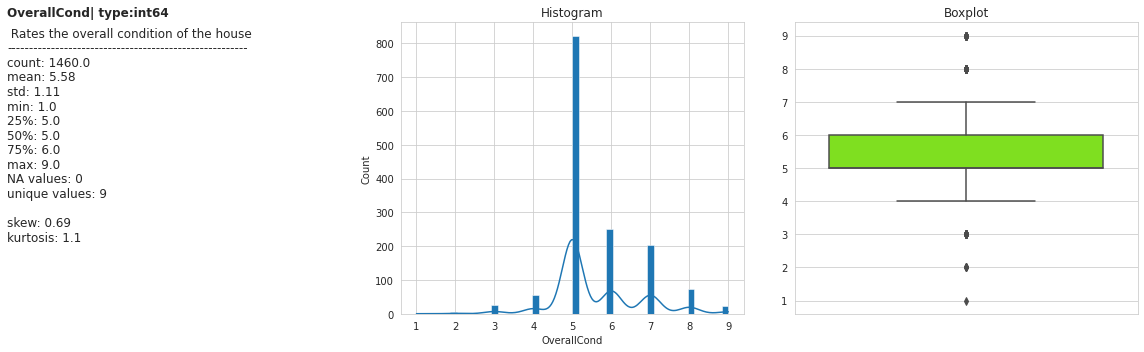

*********************************


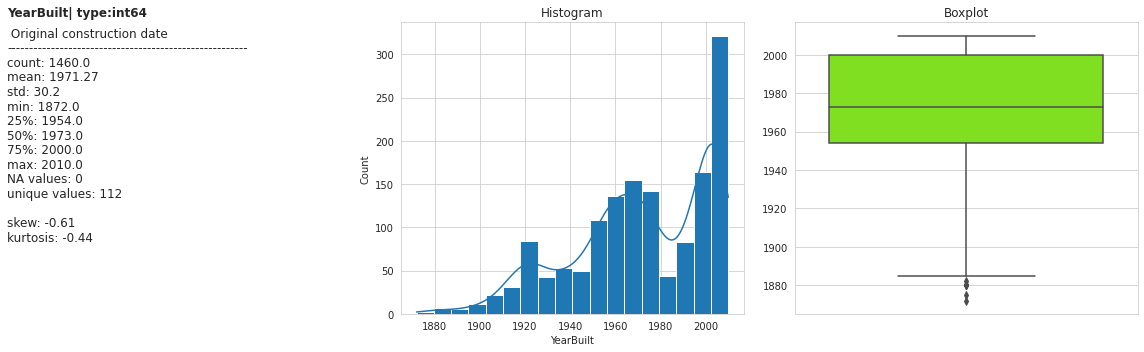

*********************************


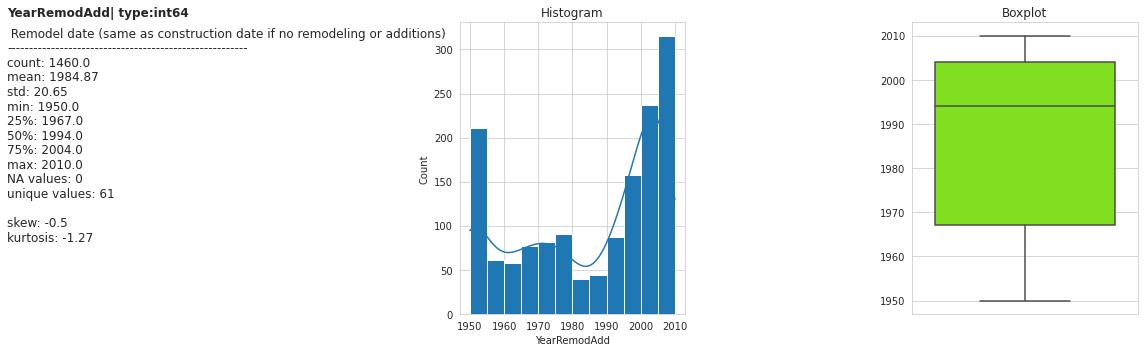

*********************************


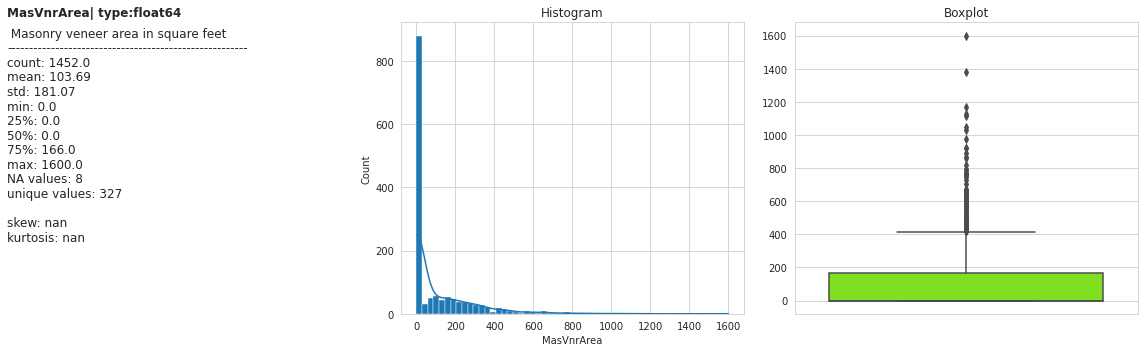

*********************************


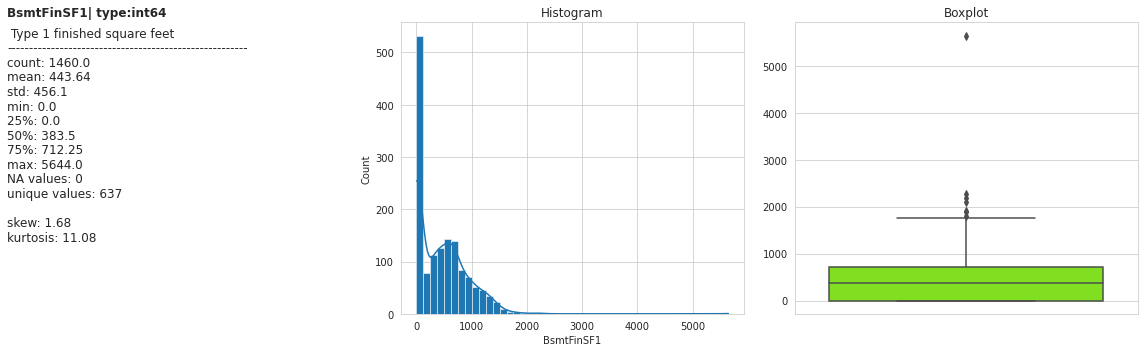

*********************************


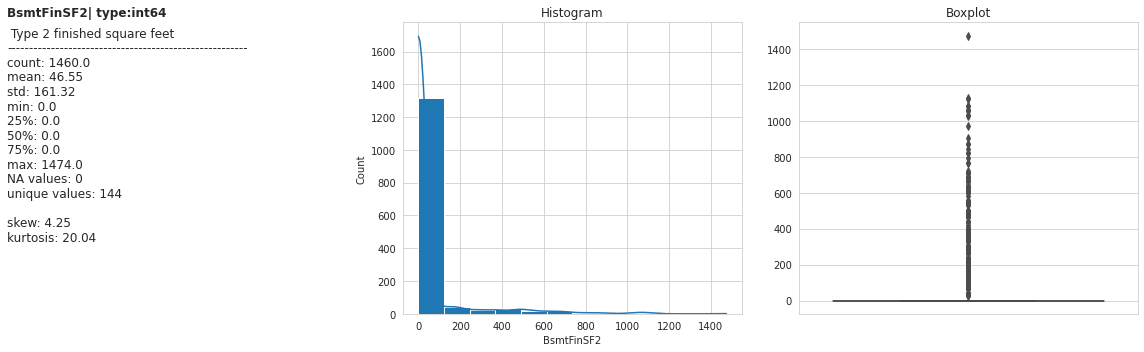

*********************************


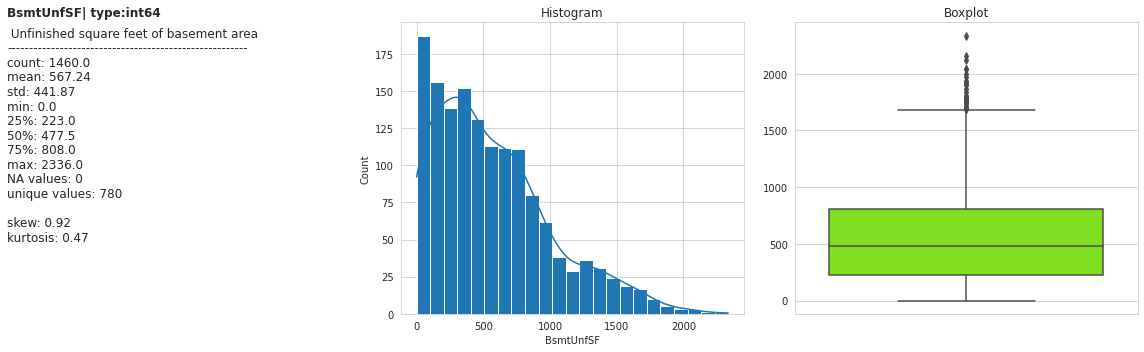

*********************************


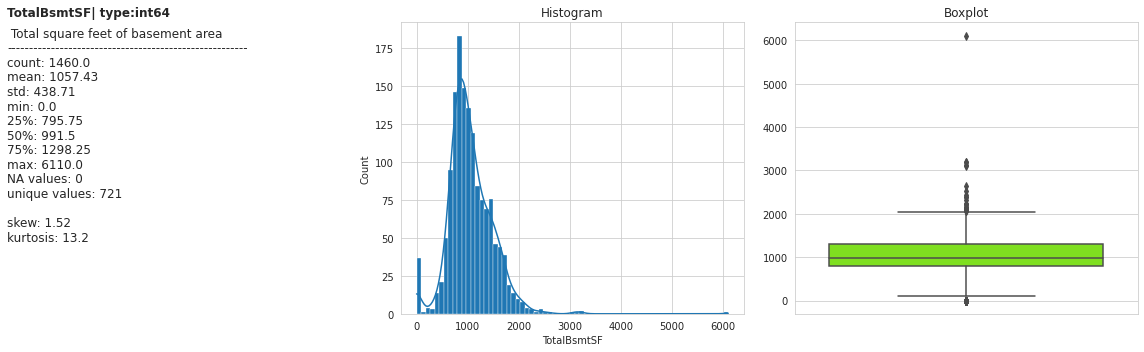

*********************************


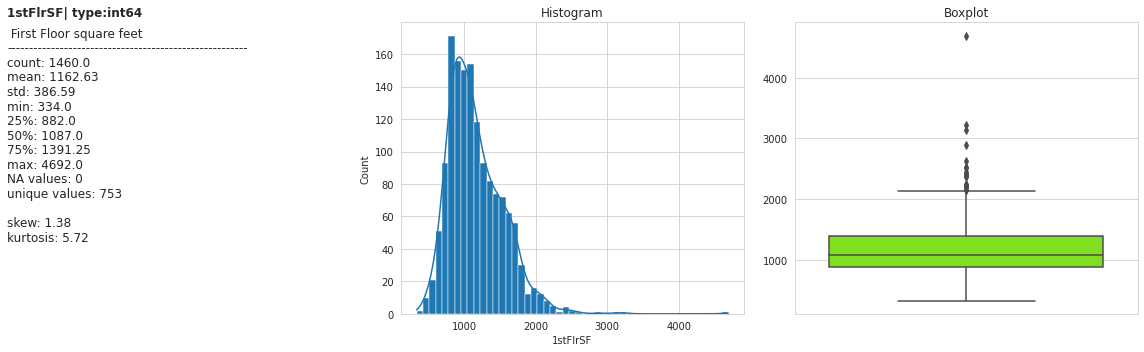

*********************************


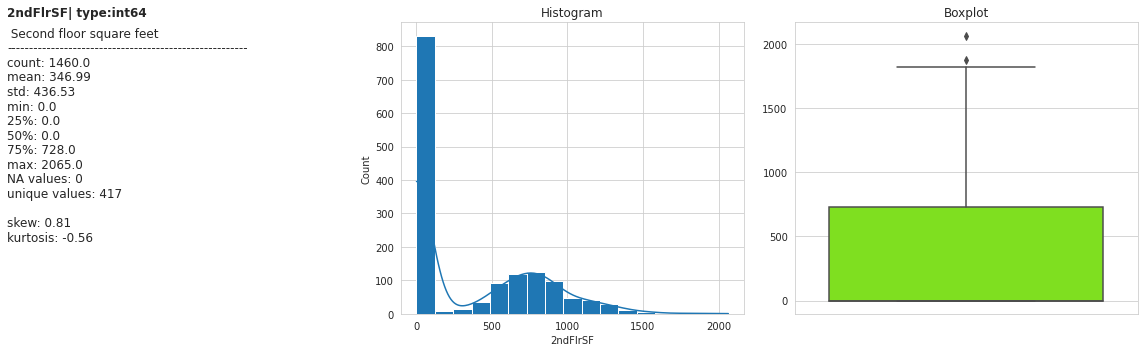

*********************************


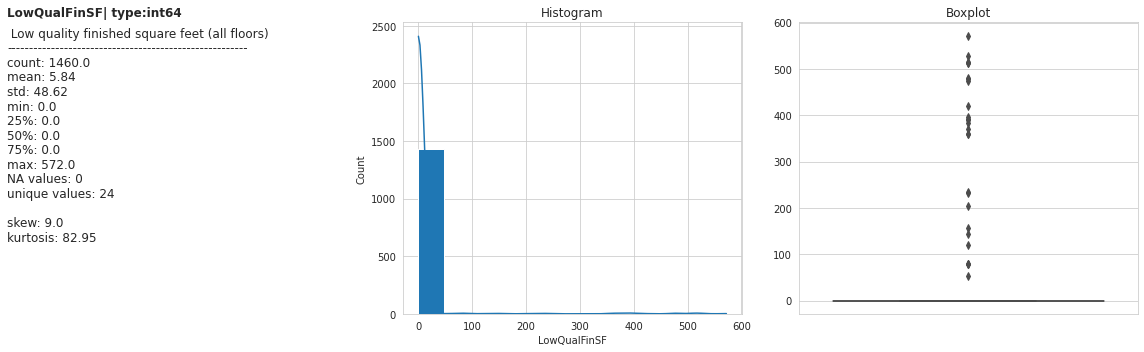

*********************************


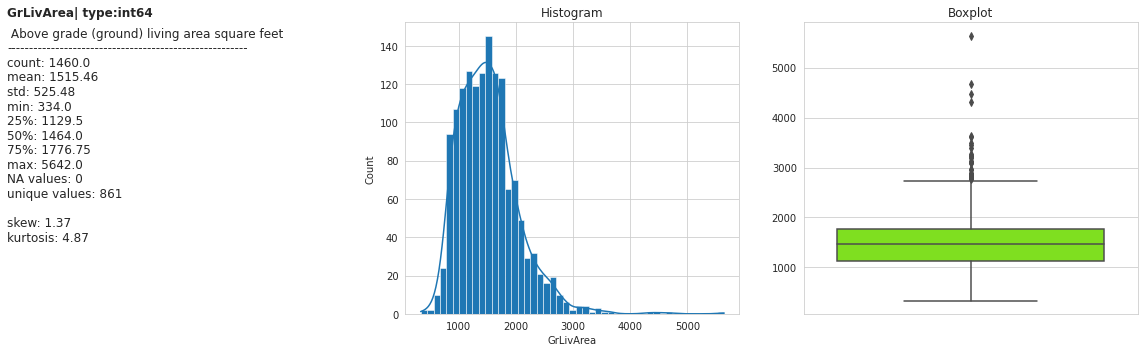

*********************************


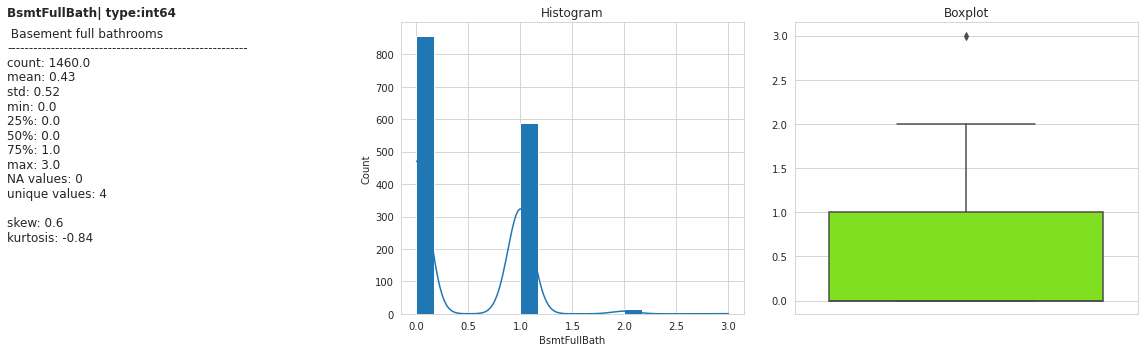

*********************************


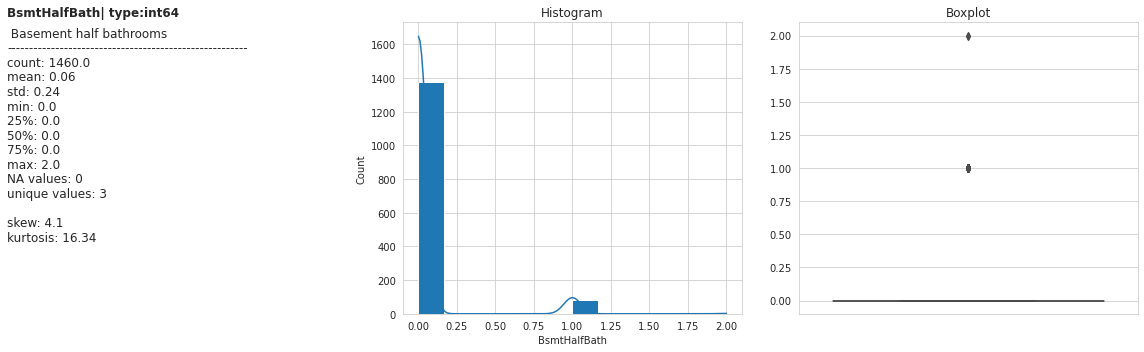

*********************************


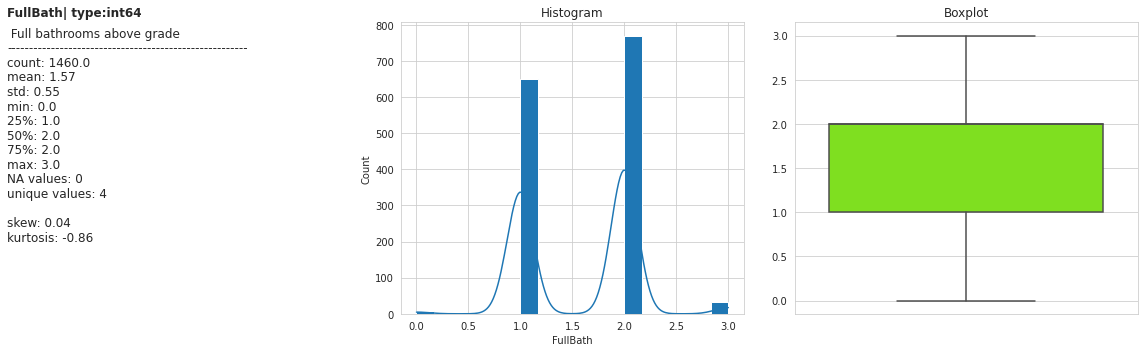

*********************************


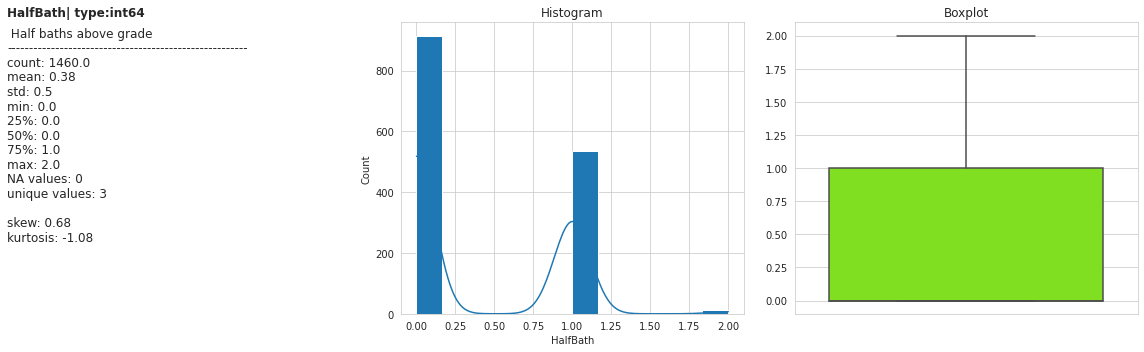

*********************************


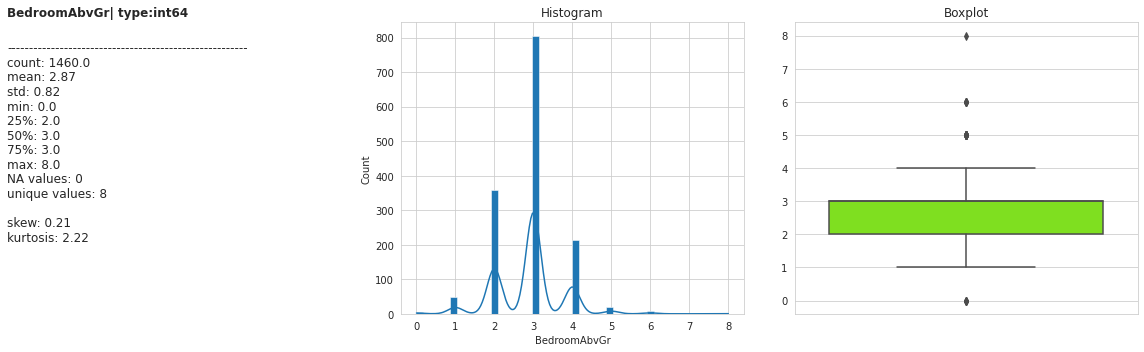

*********************************


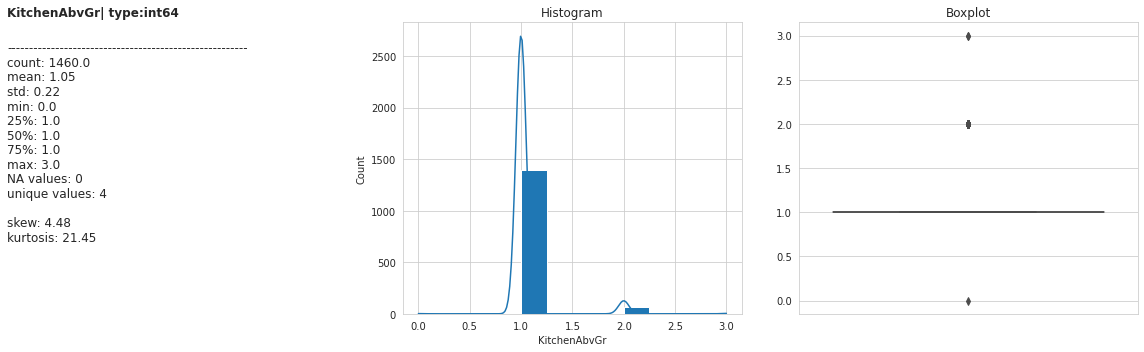

*********************************


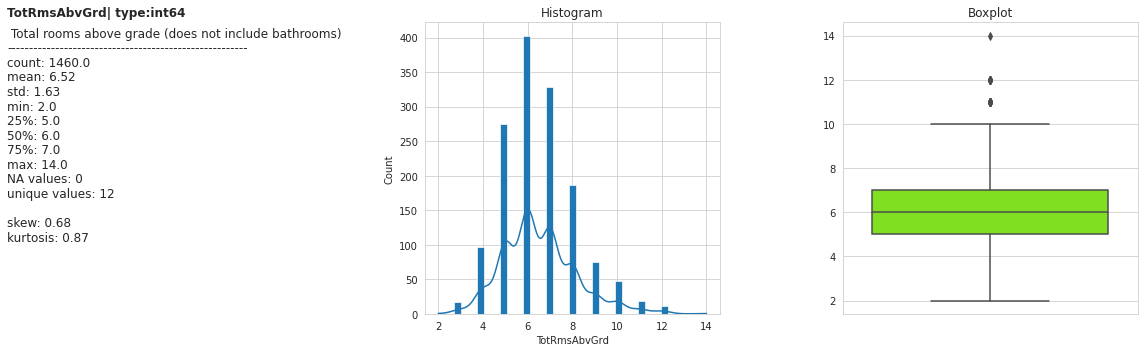

*********************************


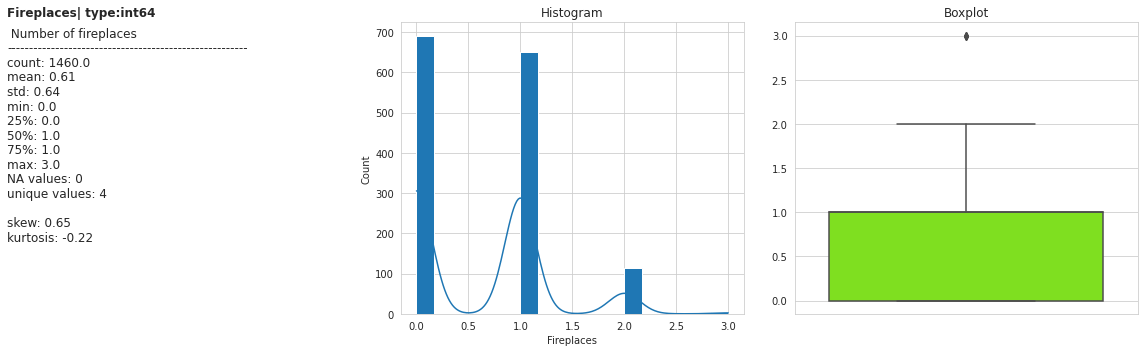

*********************************


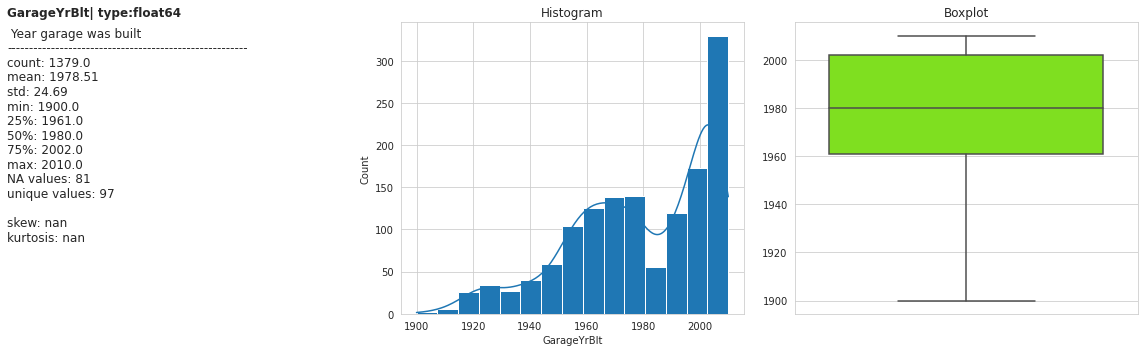

*********************************


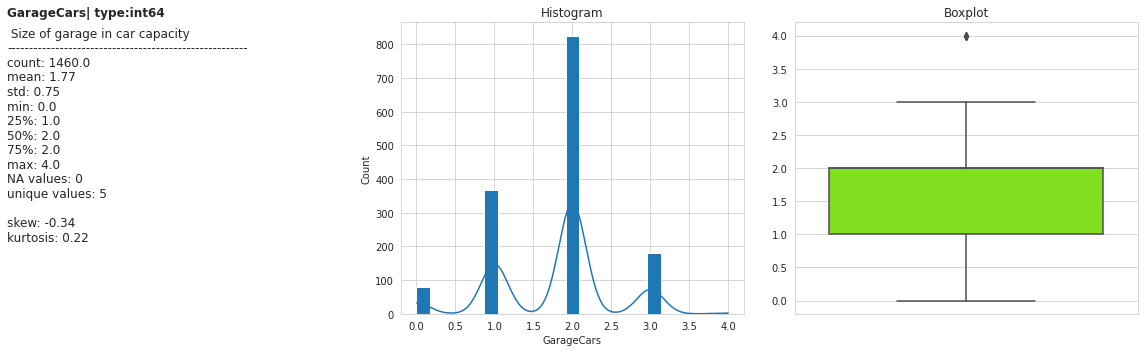

*********************************


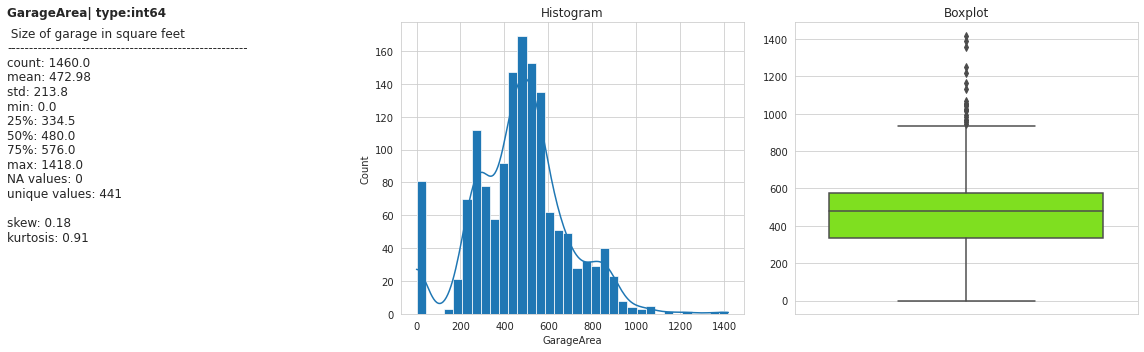

*********************************


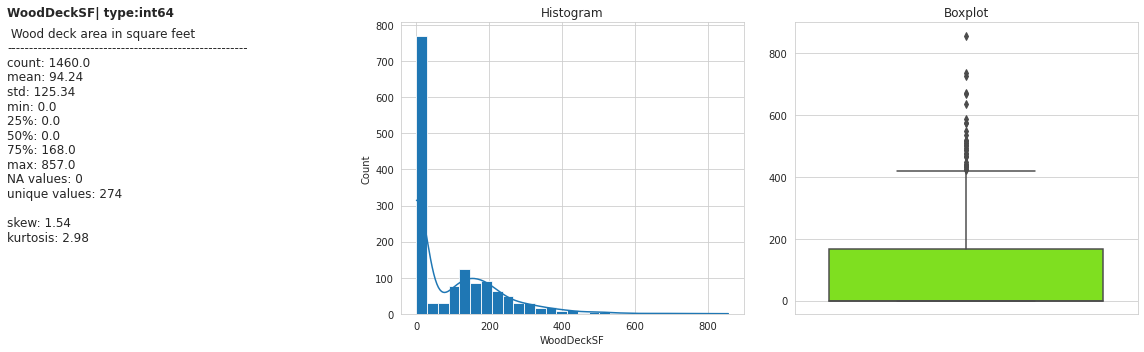

*********************************


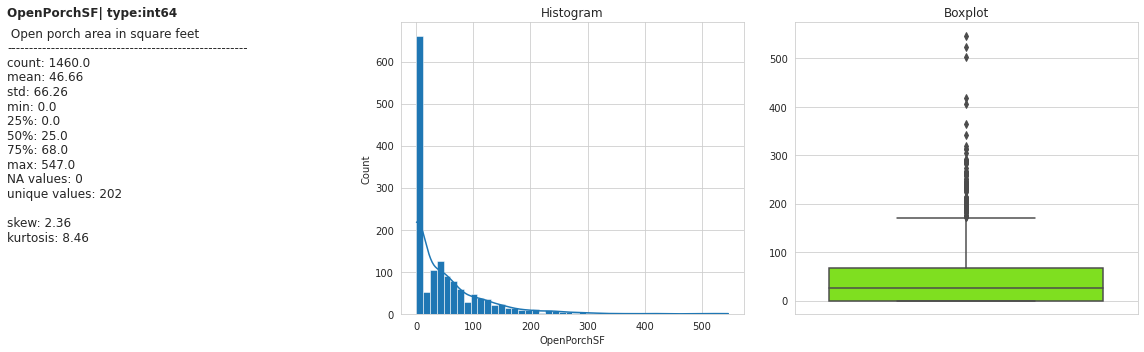

*********************************


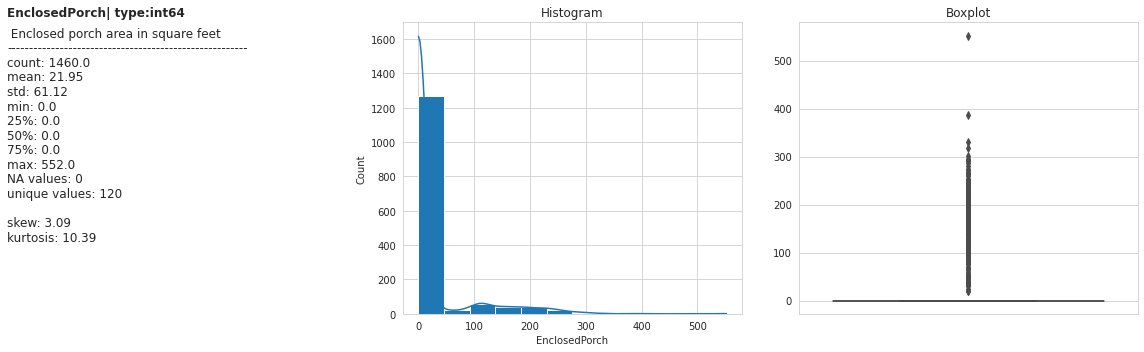

*********************************


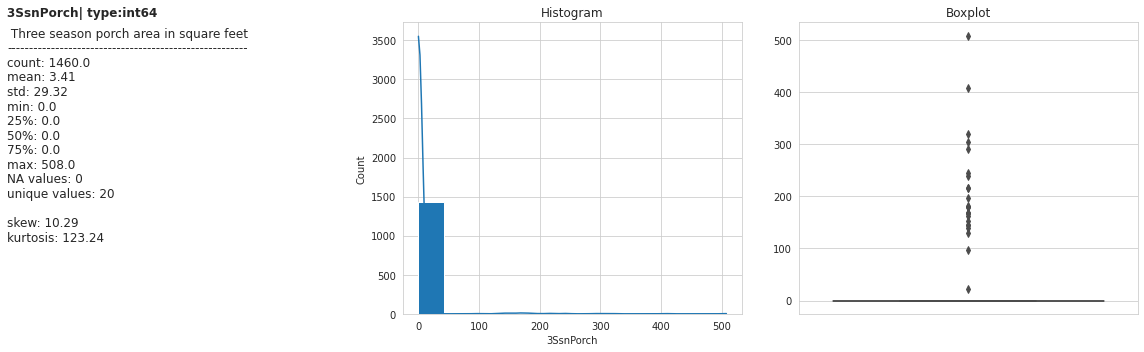

*********************************


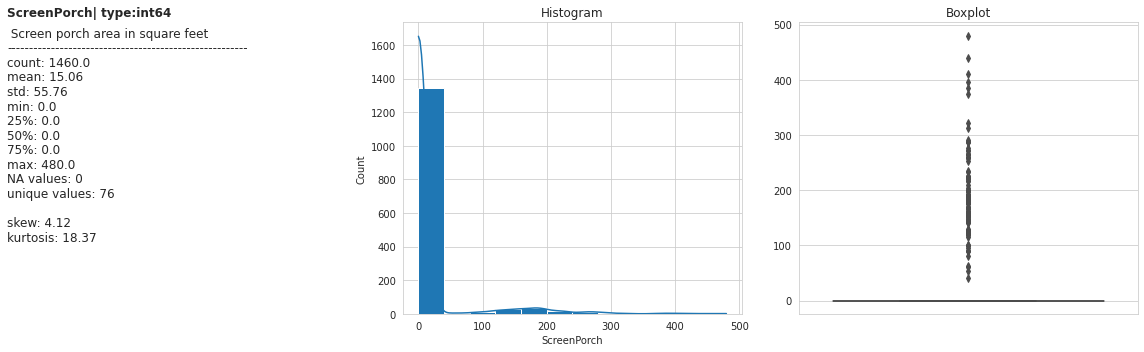

*********************************


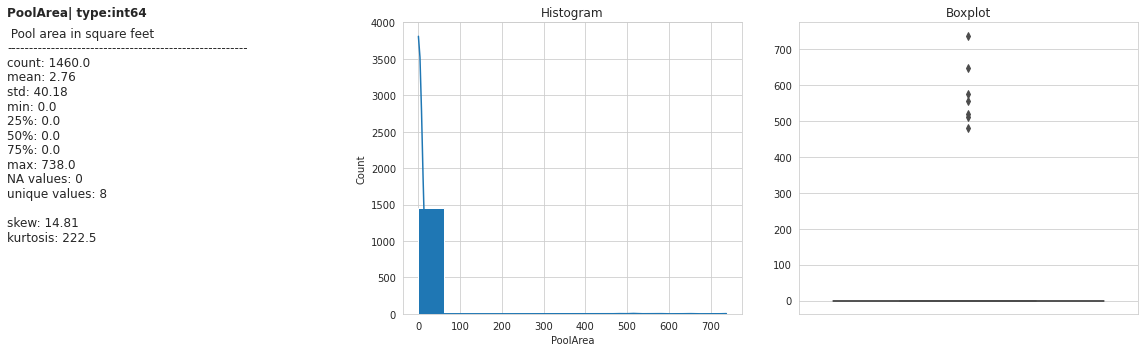

*********************************


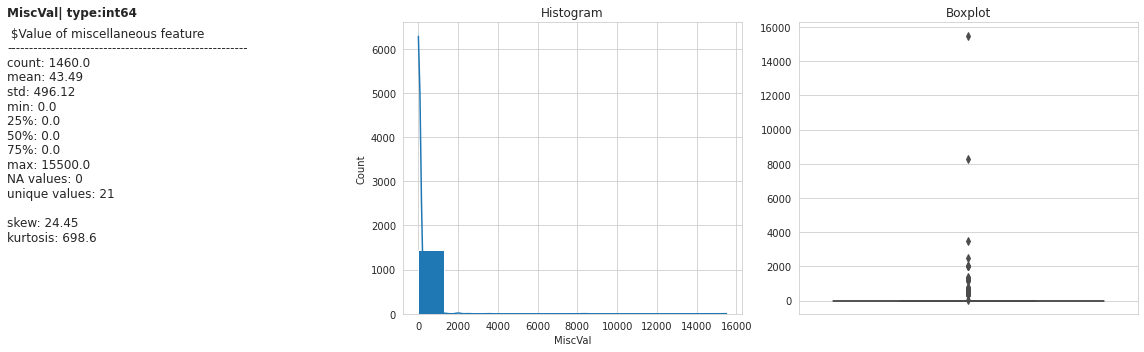

*********************************


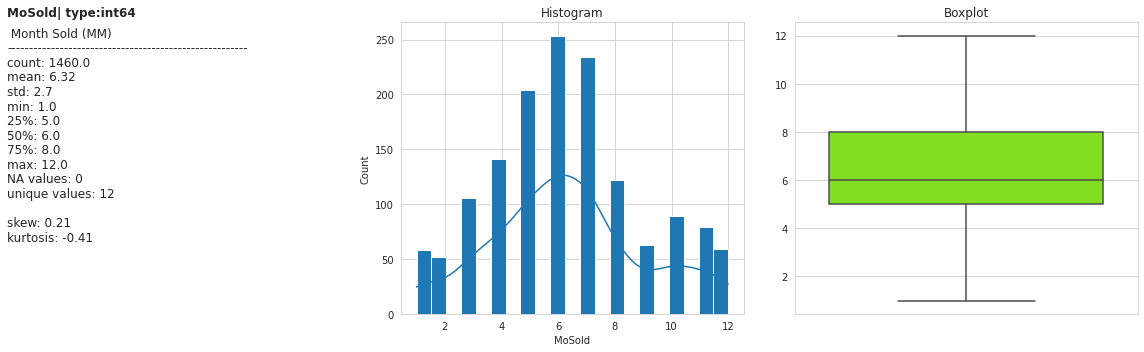

*********************************


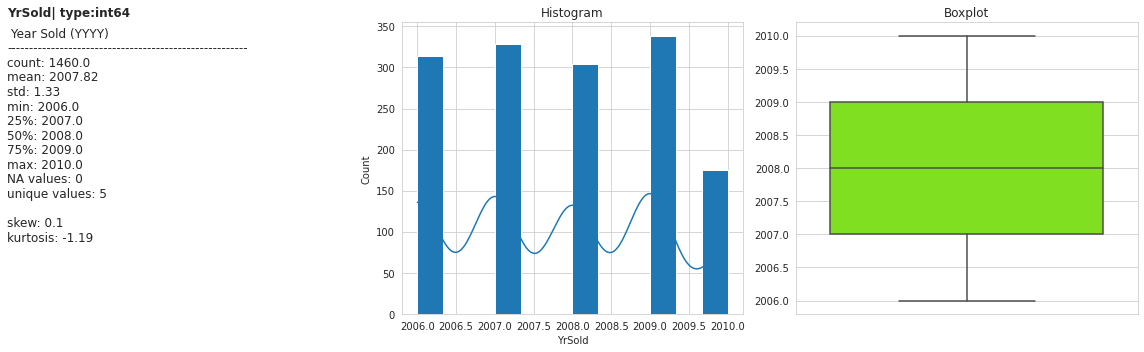

*********************************


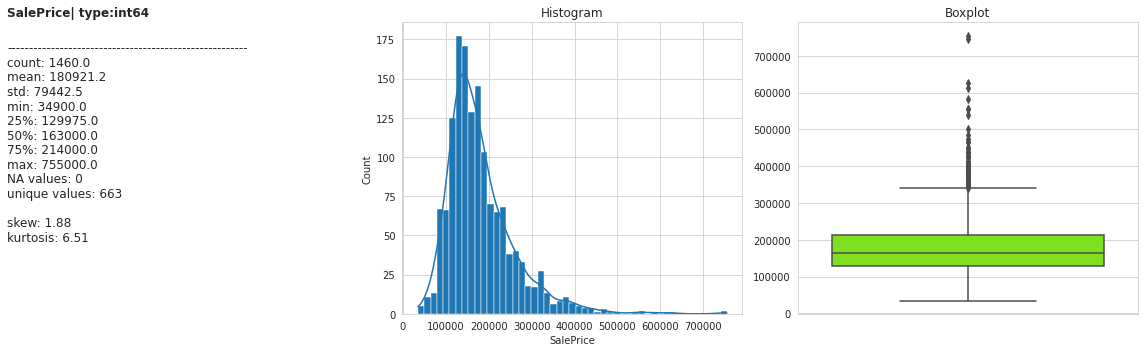

In [24]:
des_df(df_train.select_dtypes(exclude=['object']))


*********************************


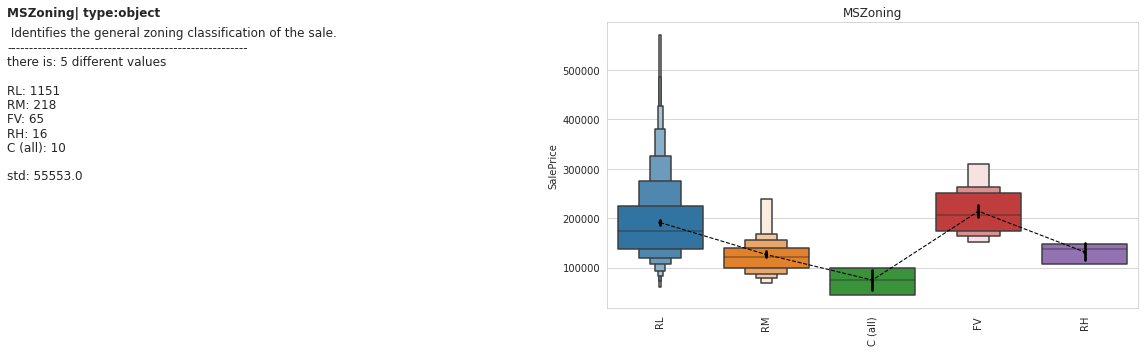

*********************************


*********************************


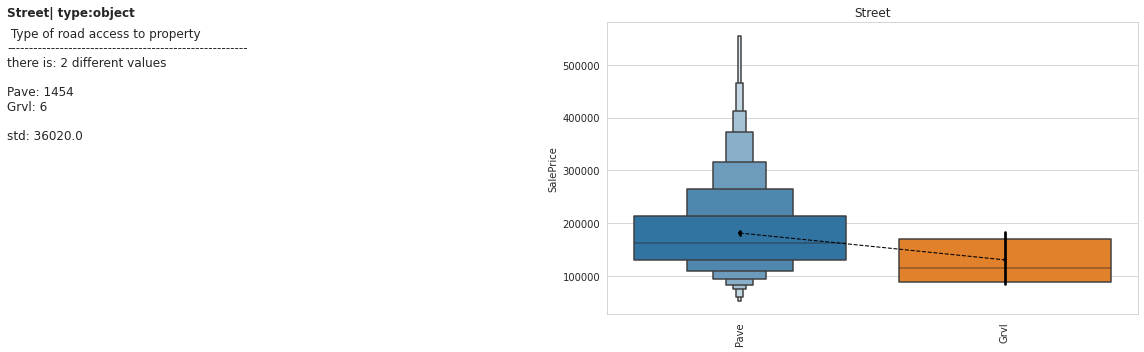

*********************************


*********************************


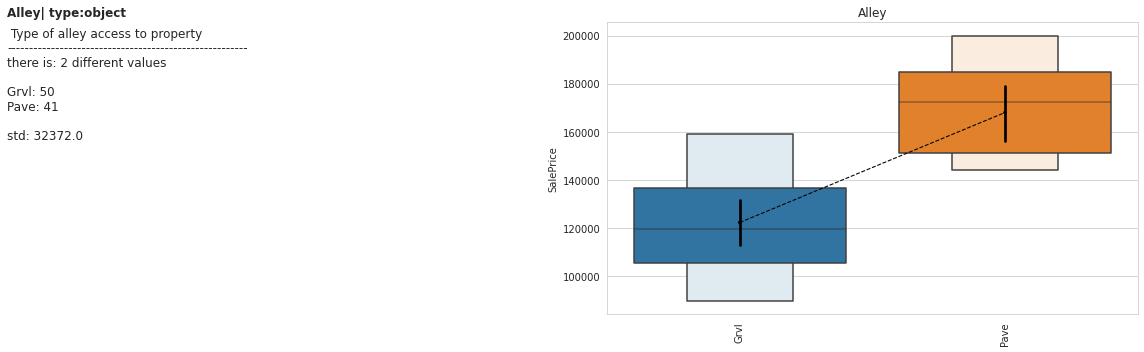

*********************************


*********************************


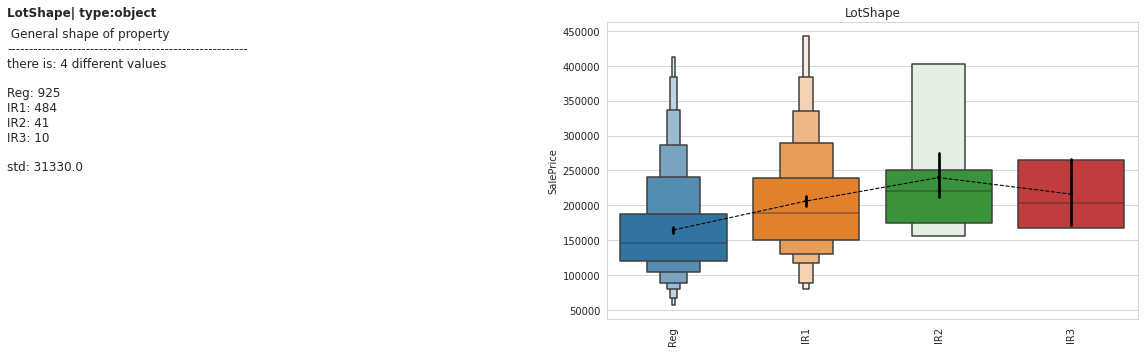

*********************************


*********************************


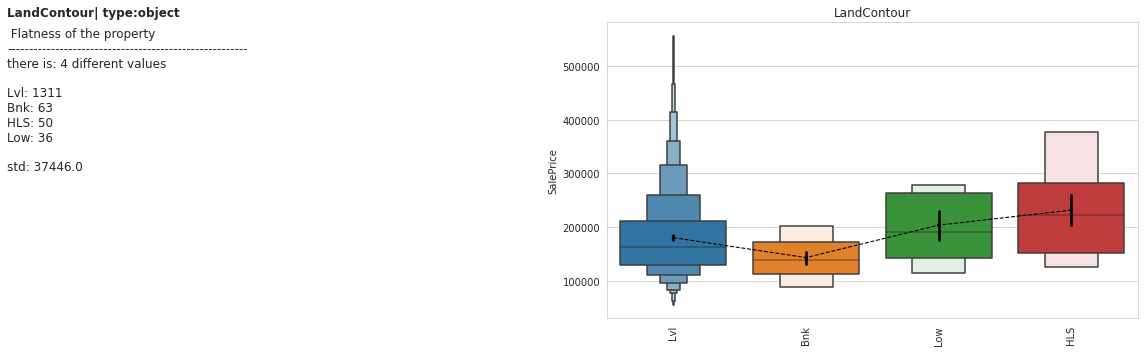

*********************************


*********************************


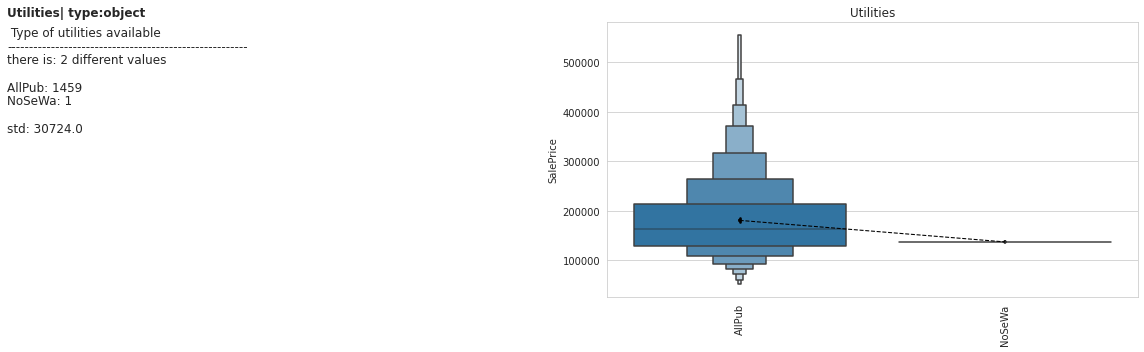

*********************************


*********************************


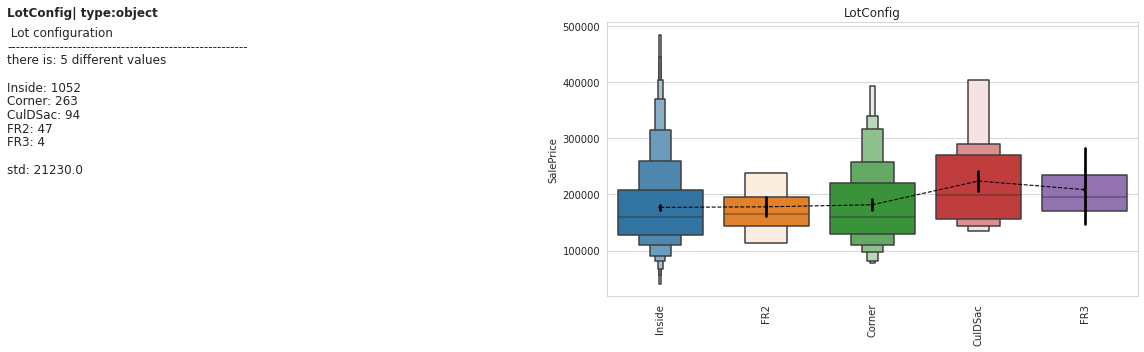

*********************************


*********************************


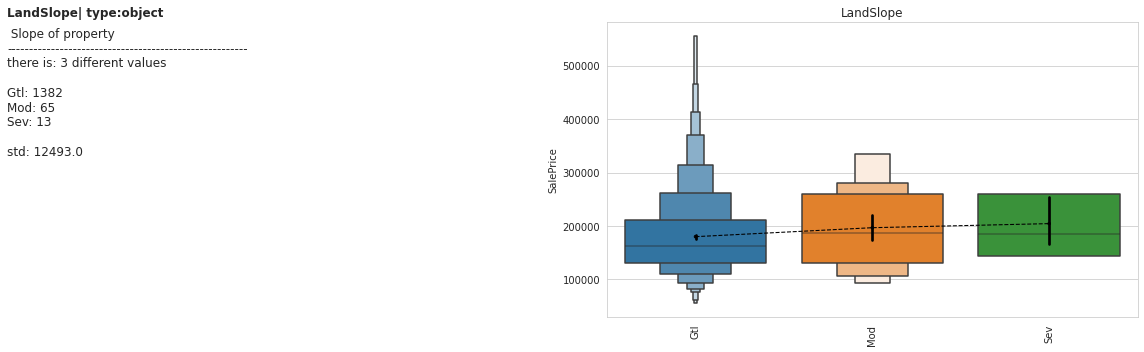

*********************************


*********************************


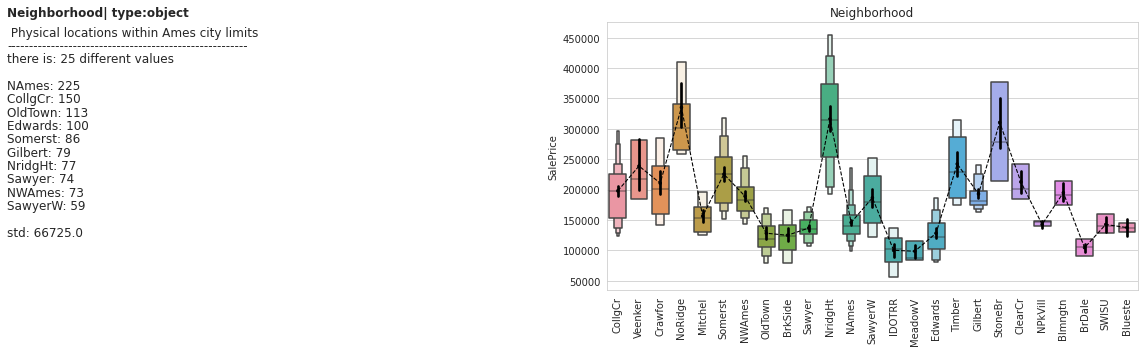

*********************************


*********************************


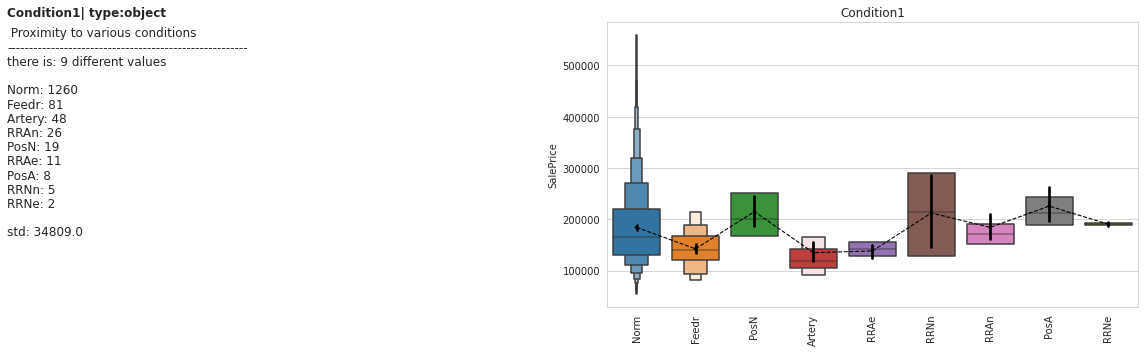

*********************************


*********************************


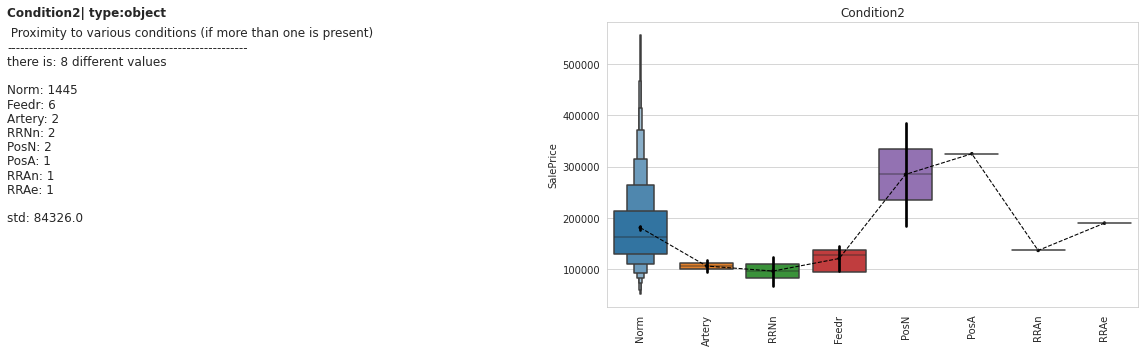

*********************************


*********************************


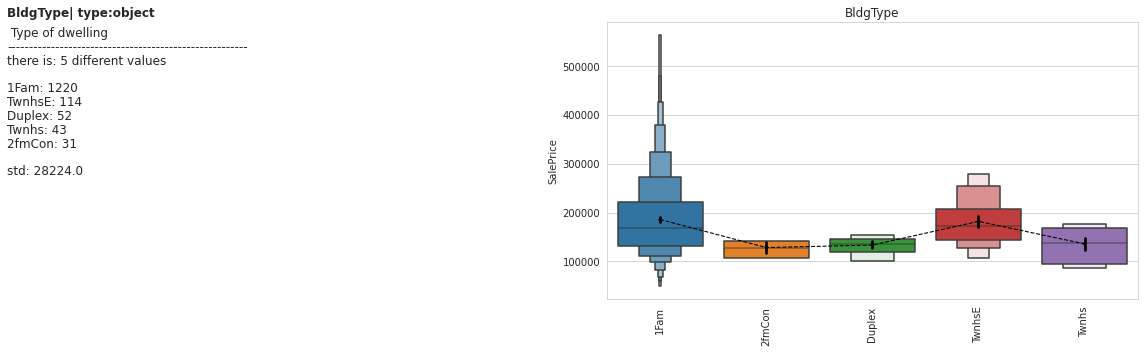

*********************************


*********************************


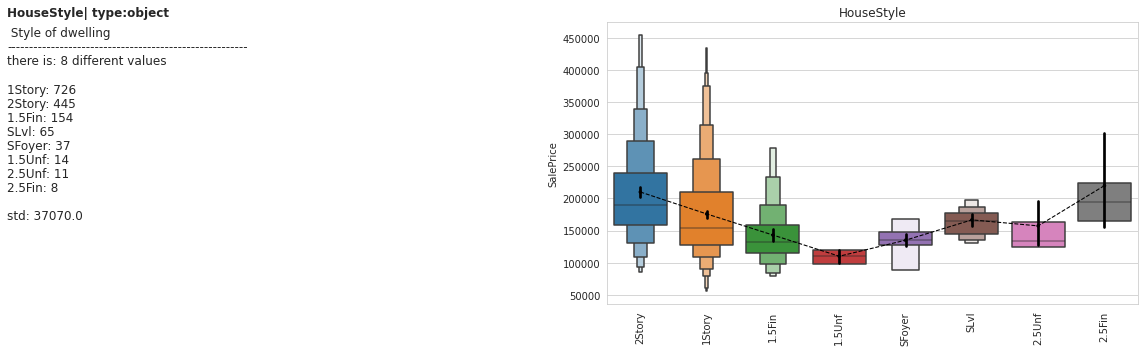

*********************************


*********************************


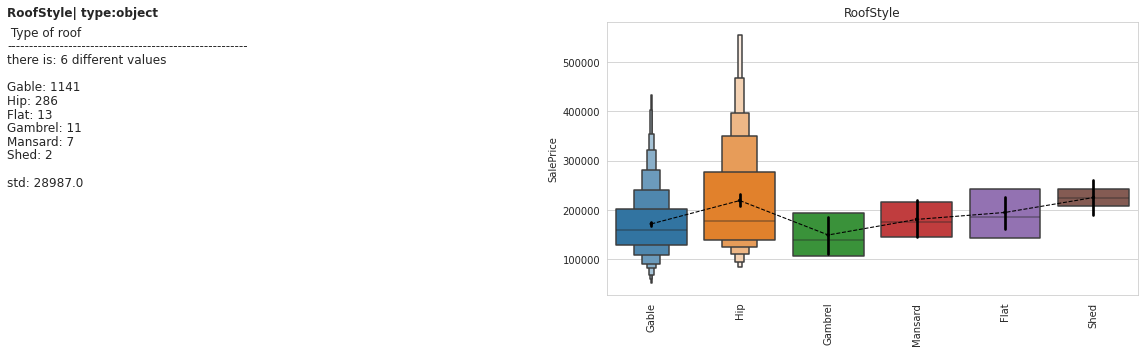

*********************************


*********************************


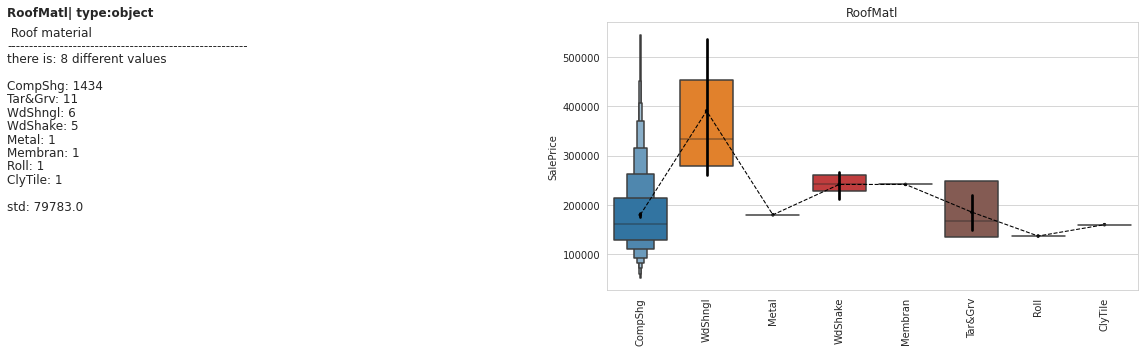

*********************************


*********************************


In [ ]:
df_cat_only_train=df_train.select_dtypes(include=['object']).copy()
df_cat_only_train.loc[:,'SalePrice'] = df_train['SalePrice'].copy()
des_df(df_cat_only_train)

# Missing values

In [ ]:
df_concat = pd.concat([df_train, df_test])
missing_vals = (pd.Series(df_concat.isna().sum()).reset_index().rename(columns={'index': 'Feature', 0: 'Missing Values'}))

In [ ]:
sns.set(rc={"figure.figsize":(10, 12)})
g=sns.barplot(data=missing_vals[missing_vals['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False), 
              x = 'Missing Values', 
              y = 'Feature'
              );

In [ ]:
def handle_na_values(df):
  for col in list(df.select_dtypes(exclude=['object']).columns):
    if df[col].isna().sum() > 0:
      df[col] = df[col].fillna(df[col].mean())    
  df = df.fillna({k: f'no_{k}' for k in df})
  return df

In [ ]:
df_train = handle_na_values(df_train)
df_test = handle_na_values(df_test)
df_concat =handle_na_values(df_concat)

# Feature engineering

In [ ]:
df_concat["GarageYrBlt"].describe()

In [ ]:
df_concat.loc[df_concat["GarageYrBlt"]>2010,"GarageYrBlt"] = 2007

In [ ]:
df_concat[df_concat['YrSold']<df_concat['YearRemodAdd']][['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt' ]]

In [ ]:
df_concat["YearRemodAdd"] = np.where(df_concat['YrSold'] < df_concat['YearRemodAdd'], df_concat['YrSold'], df_concat['YearRemodAdd'])

In [ ]:
df_concat["YrSold"] = np.where(df_concat['YrSold'] < df_concat['YearBuilt'], df_concat['YearBuilt'], df_concat['YrSold'])

In [ ]:
df_concat["age_ToS"] = df_concat["YrSold"] - df_concat["YearBuilt"]
df_concat["ageRm_ToS"] = df_concat["YrSold"] - df_concat["YearRemodAdd"]
df_concat["age_garage_sold"] = df_concat["YrSold"] - df_concat["GarageYrBlt"]
df_concat = df_concat.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis = 1)

# Categorical values encoding

In [ ]:
ordinal_cat = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC', 'KitchenQual','FireplaceQu','GarageFinish','GarageQual', 'Fence']

In [ ]:
for variable in ordinal_cat:
  for value in set(df_test.select_dtypes(include=['object'])[variable]):
    if not value in set(df_train.select_dtypes(include=['object'])[variable]):
      print(variable,value )                  

In [ ]:
df_concat.loc[df_concat["KitchenQual"]=='no_KitchenQual',"KitchenQual"] = 'Fa'

In [ ]:
for col in ordinal_cat:
    oe = OrdinalEncoder(categories=[list(df_train.groupby([col])["SalePrice"].mean().sort_values().index)])
    df_concat.loc[:, col] = oe.fit_transform(df_concat[[col]])

In [ ]:
oe = OrdinalEncoder(categories=[['no_GarageCond', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
df_concat.loc[:, 'GarageCond'] = oe.fit_transform(df_concat[['GarageCond']])
oe = OrdinalEncoder(categories=[['no_PoolQC', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
df_concat.loc[:, 'PoolQC'] = oe.fit_transform(df_concat[['PoolQC']])

In [ ]:
cols_to_dum = df_concat.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(df_concat[cols_to_dum],drop_first=True)
df_concat = df_concat.drop(cols_to_dum,axis=1)
df_final = pd.concat([df_concat, df_dummies], axis=1)

In [ ]:
df_final = df_final.drop('Id',axis=1).copy()

# Numerical data standartization

In [ ]:
df_final['SalePrice'] = np.log1p(df_final['SalePrice'])
df_final.loc[:, ~df_final.columns.isin(['SalePrice'])]= boxcox1p(df_final.loc[:, ~df_final.columns.isin(['SalePrice'])],0.15)

In [ ]:
def Split_Df(df, train_rows):
  train = df.iloc[:train_rows].copy()
  test = df.iloc[train_rows:].copy().drop('SalePrice', axis=1)
  return train, test

**Final dataframes**

In [ ]:
df_train, df_test = Split_Df(df_final, len(df_train))

**Top correlation features**

In [ ]:
corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(14,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Model - LassoCV

**Check importance of features**

In [ ]:
y = df_train['SalePrice']
X= df_train.loc[:, ~df_train.columns.isin(['SalePrice'])]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.linear_model import LassoCV
lasso = Lasso(alpha=0.0005)
lasso.fit(X_train,y_train)

In [ ]:
result = permutation_importance(lasso, X, y, n_repeats=10,
                                random_state=0)

imp = result.importances_mean


**Slice X by importance features > 0**

In [ ]:
new_cols = [X.columns[index] for index,column in enumerate(X.columns) if imp[index]>0 ]

In [ ]:
X_new=X.loc[:,new_cols]

**Lasso Regression - cross validation**

In [ ]:
Lasso2 = LassoCV(cv=5, random_state=0).fit(X_new, y)
print(f"cross validation score: {round(cross_val_score(Lasso2,X_new, y).mean(),3)}")
y_pred_lasso = Lasso2.predict(X_new)

**Check true values vs predicted** 

In [ ]:
df = pd.DataFrame({'y_true': y, 'y_pred':y_pred_lasso})
sns.regplot(data=df, x='y_true', y= 'y_pred')
plt.title('true vs predict')
plt.show()

I will take 1st and 4th quantiles of predicted values (as they not fitted line well) and try adjust values with linear regression

**1 st quantile coefs finding**

In [ ]:
y_pred_q = np.quantile(df.y_pred, np.linspace(0,1,5))

In [ ]:
df_q1 = df[(df['y_pred'] >= y_pred_q[0]) & (df['y_pred'] < y_pred_q[1])]

In [ ]:
sns.regplot(data=df_q1, x='y_true', y= 'y_pred')
plt.title('true vs predict 1st quantile')
plt.show()

In [ ]:
y_pred = df_q1[['y_pred']]
y_true= df_q1['y_true']
linreg = LinearRegression()
linreg.fit(y_pred,y_true)
icpt_q1 = linreg.intercept_
coef_q1 =linreg.coef_

print(f"1st quantile: y_true = {round(icpt_q1,4)} + {round(coef_q1[0],4)}*y_pred")

**4th quantile coefs finding**

In [ ]:
df_q4 = df[(df['y_pred'] >= y_pred_q[3]) & (df['y_pred'] < y_pred_q[4])]

In [ ]:
sns.regplot(data=df_q4, x='y_true', y= 'y_pred')
plt.title('true vs predict 4th quantile')
plt.show()

In [ ]:
y_pred = df_q4[['y_pred']]
y_true= df_q4['y_true']
linreg = LinearRegression()
linreg.fit(y_pred,y_true)
icpt_q4 = linreg.intercept_
coef_q4 =linreg.coef_

print(f"4th quantile: y_true = {round(icpt_q4,4)} + {round(coef_q4[0],4)}*y_pred")

I will apply those numbers later to final prediction.

# Prediction submission

**Slicing test dataset**

In [ ]:
df_test=df_test.loc[:,new_cols]

In [ ]:
y_pred=Lasso2.predict(df_test)

**Prediction adjustment**

In [ ]:
y_pred_q = np.quantile(y_pred, np.linspace(0,1,5))
y_pred = np.where((y_pred>=y_pred_q[0]) & (y_pred<y_pred_q[1]),icpt_q1 + y_pred*coef_q1, y_pred)
y_pred = np.where((y_pred>=y_pred_q[3]) & (y_pred<y_pred_q[4]),icpt_q4 + y_pred*coef_q4, y_pred)

In [ ]:
y_pred = np.expm1(y_pred)

**Final submission**

In [ ]:
df_newsub =pd.DataFrame({"Id" : test_id, 'SalePrice': y_pred})
df_newsub.head()

In [ ]:
df_newsub.to_csv("submission.csv", index = False)